# Zadanie 1: Mnożenie macierzy
- Jakub Karbowski
- Jakub Szymczak

## Metoda rekurencyjna Binet'a

Polega na podziale macierzy na 4 równe bloki i rekurencyjnym wywoływaniu aż do przypadku granicznego, którym jest mnożenie skalarów.

$$
A = \left(
\begin{matrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{matrix}
\right)
,
B = \left(
\begin{matrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{matrix}
\right)
,
C = \left(
\begin{matrix}
C_{11} & C_{12} \\
C_{21} & C_{22}
\end{matrix}
\right)
$$

$$
\left(
\begin{matrix}
C_{11} & C_{12} \\
C_{21} & C_{22}
\end{matrix}
\right)
=
\left(
\begin{matrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{matrix}
\right)
\left(
\begin{matrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{matrix}
\right)
=
\left(
\begin{matrix}
A_{11} B_{11} + A_{12} B_{12} & A_{11} B_{12} + A_{12} B_{22} \\
A_{21} B_{11} + A_{22} B_{21} & A_{21} B_{12} + A_{22} B_{22}
\end{matrix}
\right)
$$

```python
def binet_mul(a: Mat, b: Mat) -> Mat:
    assert len(a) == len(a[0]) == len(b) == len(b[0])
    n = len(a)

    if n == 1:
        # base case scalar multiplication
        return [[a[0][0] * b[0][0]]]
    else:
        assert n % 2 == 0
        # block size
        m = n // 2
        
        # input blocks
        a11 = mat_slice(a, 0, m, 0, m)
        a12 = mat_slice(a, 0, m, m, n)
        a21 = mat_slice(a, m, n, 0, m)
        a22 = mat_slice(a, m, n, m, n)

        b11 = mat_slice(b, 0, m, 0, m)
        b12 = mat_slice(b, 0, m, m, n)
        b21 = mat_slice(b, m, n, 0, m)
        b22 = mat_slice(b, m, n, m, n)

        # recursive calls
        c11 = mat_add(binet_mul(a11, b11), binet_mul(a12, b21))
        c12 = mat_add(binet_mul(a11, b12), binet_mul(a12, b22))
        c21 = mat_add(binet_mul(a21, b11), binet_mul(a22, b21))
        c22 = mat_add(binet_mul(a21, b12), binet_mul(a22, b22))

        # combine blocks
        c = mat_zeros(n, n)
        for i in range(m):
            for j in range(m):
                c[i][j] = c11[i][j]
                c[i][j + m] = c12[i][j]
                c[i + m][j] = c21[i][j]
                c[i + m][j + m] = c22[i][j]

        return c
```

### Wydajność

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('binet.csv')

Zmierzono liczbę operacji zmiennoprzecinkowych `+ *` w zależności od rozmiaru macierzy.
Do pomiarów wpasowano wielomian $y=ax^3$.

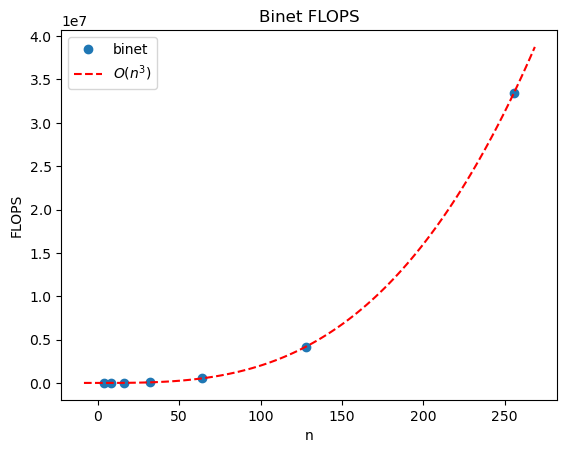

In [57]:
plt.plot(df['n'], df['flops_binet'], 'o', label='binet')

x = df['n']
y = df['flops_binet']
p = np.polyfit(x, y, 3)
p[1:] = 0
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, np.polyval(p, x), 'r--', label='$O(n^3)$')

plt.legend()
plt.title('Binet FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

Zmierzono również czas, który został porównany z implementacją `numpy.matmul`.

/var/folders/sd/yrr8ypm52gv1wbxvgg_8f1b40000gn/T/ipykernel_27068/3762522458.py:21: RuntimeWarning: invalid value encountered in power
  return a * x**b


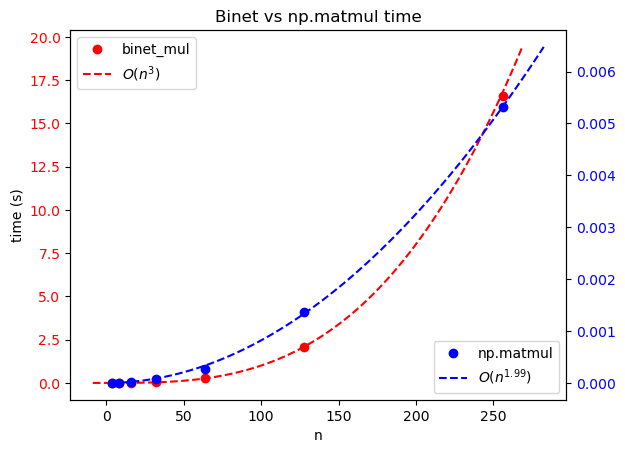

In [58]:
import scipy.optimize

fig, ax1 = plt.subplots()
ax1.set_xlabel('n')
ax1.set_ylabel('time (s)')
ax1.tick_params(axis='y', labelcolor='red')
ax1.plot(df['n'], df['time_binet'], 'o', label='binet_mul', color='red')

x = df['n']
y = df['time_binet']
p = np.polyfit(x, y, 3)
p[1:] = 0
x = np.linspace(*plt.xlim(), 100)
ax1.plot(x, np.polyval(p, x), 'r--', label='$O(n^3)$')

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='blue')
ax2.plot(df['n'], df['time_np'], 'o', label='np.matmul', color='blue')

def f(x, a, b):
    return a * x**b

x = df['n'].astype(np.float64)
y = df['time_np'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y, bounds=([1e-10, 1.1], [1e-1, 3]), p0=[1e-2, 2])
x = np.linspace(*plt.xlim(), 100)
ax2.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

ax1.legend()
ax2.legend(loc='lower right')
plt.title('Binet vs np.matmul time')
plt.show()

Algorytm Binet'a ma złożoność $O(n^3)$, a algorytm stosowany w `numpy` ma mniejszą złożoność.
Do pomiarów czasów `numpy` została wpasowana złożoność $O(n^{1.99})$, co wydaje się błędne.
Może to być efekt stosowanych heurystyk lub po prostu błąd pomiaru czasu.

## Metoda Strassen'a

Polega na podziale macierzy na 4 równe bloki i rekurencyjnym wywoływaniu aż do przypadku granicznego, którym jest mnożenie skalarów. Różni się od metody Binet'a wzorami na poszczególne podmacierze.

$$
\left(
\begin{matrix}
C_{11} & C_{12} \\
C_{21} & C_{22}
\end{matrix}
\right)
=
\left(
\begin{matrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{matrix}
\right)
\left(
\begin{matrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{matrix}
\right)
=
\left(
\begin{matrix}
P_{1} + P_{4} - P_{5} + P_{7} & P_{3} + P_{5} \\
P_{2} + P_{4} & P_{1} - P_{2} + P_{3} + P_{6} 
\end{matrix}
\right)
$$

$$
P_{1} = ( A_{11} + A_{22} )(B_{11} + B_{22}) \\
P_{2} = ( A_{21} + A_{22} )B_{11} \\
P_{3} = A_{11}( B_{12} - B_{22} ) \\
P_{4} = A_{22}( B_{21} - B_{11} ) \\
P_{5} = ( A_{11} + A_{12} )B_{22} \\
P_{6} = ( A_{21} - A_{11} )(B_{11} + B_{12}) \\
P_{7} = ( A_{12} - A_{22} )(B_{21} + B_{22}) \\
$$


```python
def strassen(x, y):
    if len(x) == 1:
        multiply_count += 1
        return x * y

    a11, a12, a21, a22 = split(x)
    b11, b12, b21, b22 = split(y)

    #recursive calls
    p1 = strassen(a11 + a22, b11 + b22)
    p2 = strassen(a21 + a22, b11)
    p3 = strassen(a11, b12 - b22)
    p4 = strassen(a22, b21 - b11)
    p5 = strassen(a11 + a12, b22)
    p6 = strassen(a21 - a11, b11 + b12)
    p7 = strassen(a12 - a22, b21 + b22)

    #add results
    c11 = p1 + p4 - p5 + p7
    c12 = p3 + p5    
    c21 = p2 + p4    
    c22 = p1 - p2 + p3 + p6

    #combine blocks
    c = np.vstack((np.hstack((c11, c12)), np.hstack((c21, c22))))

    return c
```

### Wydajność

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_strassen = pd.read_csv('strassen.csv')

/var/folders/sd/yrr8ypm52gv1wbxvgg_8f1b40000gn/T/ipykernel_27068/2722432332.py:4: RuntimeWarning: invalid value encountered in power
  return a * x**b


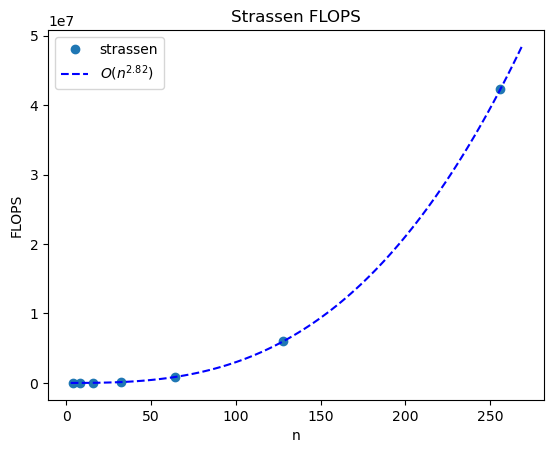

In [60]:
plt.plot(df_strassen['n'], df_strassen['flops_strassen'], 'o', label='strassen')

def f(x, a, b):
    return a * x**b

x = df_strassen['n'].astype(np.float64)
y = df_strassen['flops_strassen'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

plt.legend()
plt.title('Strassen FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

/var/folders/sd/yrr8ypm52gv1wbxvgg_8f1b40000gn/T/ipykernel_27068/4231977893.py:10: RuntimeWarning: invalid value encountered in power
  return a * x**b
/var/folders/sd/yrr8ypm52gv1wbxvgg_8f1b40000gn/T/ipykernel_27068/4231977893.py:23: RuntimeWarning: invalid value encountered in power
  return a * x**b


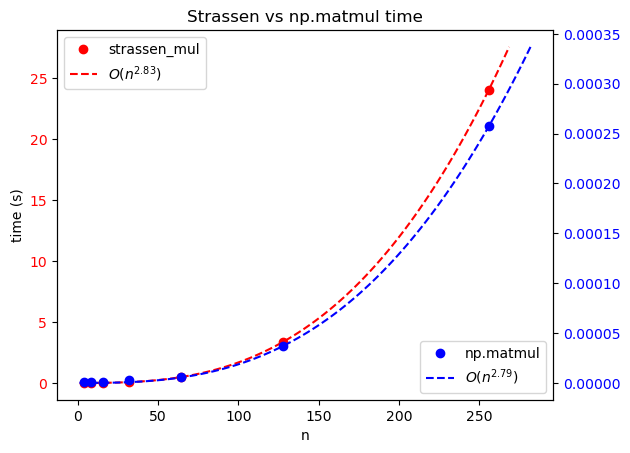

In [61]:
import scipy.optimize

fig, ax1 = plt.subplots()
ax1.set_xlabel('n')
ax1.set_ylabel('time (s)')
ax1.tick_params(axis='y', labelcolor='red')
ax1.plot(df_strassen['n'], df_strassen['time_strassen'], 'o', label='strassen_mul', color='red')

def f(x, a, b):
    return a * x**b

x = df_strassen['n'].astype(np.float64)
y = df_strassen['time_strassen'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
ax1.plot(x, f(x, *popt), 'r--', label=f'$O(n^{{{popt[1]:.2f}}})$')

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='blue')
ax2.plot(df_strassen['n'], df_strassen['time_np'], 'o', label='np.matmul', color='blue')

def f(x, a, b):
    return a * x**b

x = df_strassen['n'].astype(np.float64)
y = df_strassen['time_np'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y)
x = np.linspace(*plt.xlim(), 100)
ax2.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

ax1.legend()
ax2.legend(loc='lower right')
plt.title('Strassen vs np.matmul time')
plt.show()

Złożoność zmierzona pokrywa się z teoretyczną.